In [13]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dataextractor import get_data
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [3]:
# Step 1 − Collecting the Dataset
df = get_data(return_DF=True)

# Step 2− Preprocessing the Data

# Remove URLs
df['text'] = df['text'].apply(lambda x: re.compile(r'https?://\S+|www\.\S+').sub(r'',x))
# Remove @users:
df['text'] = df['text'].apply(lambda x: re.compile(r'@([A-Za-z])+').sub(r'',x))
# Remove HTML:
df['text'] = df['text'].apply(lambda x: re.compile(r'<.*?>').sub(r'',x))
# Remove emojis:
df['text'] = df['text'].apply(lambda x: re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE).sub(r'',x))
# Transform shortened words in full form:
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

df['text'] = df['text'].apply(lambda x: decontraction(x))
# Remove punctuation
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
# Keep only letters
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
# Lower case
df['text'] = df['text'].apply(lambda x: x.lower())
# Remove stop words
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in set(stopwords.words('english'))]))

# Step 3− Creating the TF-IDF Matrix
X = df['text']
y = df['label'].apply(lambda x: {'positive':1.0,'neutral':0.0,'negative':-1.0}[x])

# Step 4− Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



saved


In [ ]:
# TEST.csv heeft de preprocessing al gedaan. Duurt namelijk zo'n 6 minuten. Je kan m in principe hergebruiken, of gwn die cell runnen

Length all instances: 50131
0.0: 22523
1.0: 19799
-1.0: 7809
Vocabulary size: 47111
#Tokens: 569160


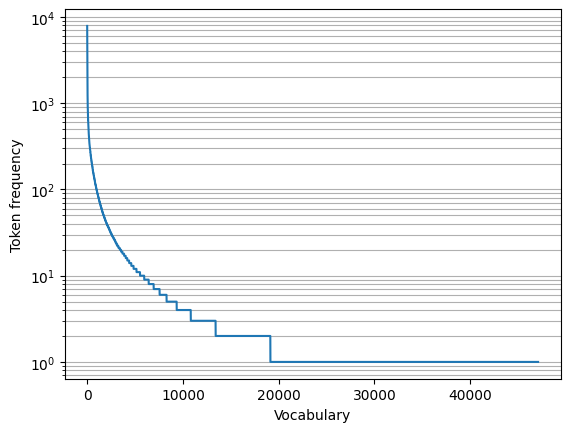

Occuring >1: 19134
Top-4 0.8016174566449449
Top-50 0.9639999150941394
Top-5 words: [('tomorrow', 7888), ('may', 7407), ('th', 6392), ('c', 5417), ('day', 4614)]


In [4]:
def stats():
    # Length
    print(f"Length all instances: {len(X)}")
    
    # Positive/negative/neutral
    for unique in set(y):
        print(f"{unique}: {len(y[(y == unique)])}")

    # Length based on split whitespace
    vocab = {}
    for text in X:
        l = str(text).split()
        for j in l:
            vocab[j] = vocab.get(j,0) + 1
    

    print("Vocabulary size:",len(vocab))
    print("#Tokens:",sum(vocab.values()))
    plt.plot(range(len(vocab.keys())),sorted(list(vocab.values()))[::-1])
    plt.yscale('log')
    plt.ylabel('Token frequency')
    plt.xlabel('Vocabulary')
    plt.grid(True, which='both',axis='y',ls='-')
    plt.show()

    # Most occuring words
    print("Occuring >1:",sum([vocab[i] >1 for i in vocab.keys()]))
    print("Top-4",sum([vocab[i] <=4 for i in vocab.keys()])/len(vocab))
    print("Top-50",sum([vocab[i] <=50 for i in vocab.keys()])/len(vocab))
    print("Top-5 words:",sorted(list(vocab.items()),key=lambda x: x[1])[::-1][:5])

stats()

In [14]:
print("TRAIN")
print(X.head(),y.head())

# Step 5− Set up pipeline
model = Pipeline([
        ('vect',CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf',SVR())])

model.fit(X_train, y_train)

TRAIN
0    match getin plusu c tomorrow busy dayu c aware...
1    area new england could see first flake season ...
2    con nd worst qb definitely tony romo man like ...
3    thailand washington u president barack obama v...
4    yu hear tony romo dressed halloween giant quat...
Name: text, dtype: object 0    0.0
1    0.0
2   -1.0
3    0.0
4    0.0
Name: label, dtype: float64


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVR())])

In [11]:
# Step 6− Evaluating the Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='weighted')
f1mi = f1_score(y_test, y_pred, average='micro')
f1ma = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")
print(f"F1 score (weighted): {f1:}")
print(f"F1 score (micro): {f1mi:}")
print(f"F1 score (macro): {f1ma:}")

# Observe some mistakes
eval_df = pd.DataFrame({"X":X_test,"y":y_test, "y_pred":y_pred})
print(eval_df[eval_df['y']!=eval_df['y_pred']].head())

Accuracy: 0.6081579734716266
Precision: 0.7088691084018187
Recall: 0.4814519191276187
F1 score (weighted): 0.5621998481907803
F1 score (micro): 0.6081579734716266
F1 score (macro): 0.4520059829479573
                                                      X    y  y_pred
1003  gruesome terrible injury marcus lattimore nd y... -1.0     0.0
4156  let see good vibration trap queen bad blood re...  1.0     0.0
536   know president reagan made july national ice c...  0.0     1.0
7013  praying st nd wave leader going x factor leade...  1.0     0.0
2790             think going flash galaxy note tomorrow  1.0     0.0


In [7]:
X.to_csv("TEST")

# Je kan experimenteren met preprocessing, of verschillende classifiers (NB, LR, SVR, etc.)